In [1]:
%run data.py

In [2]:
results_df = fetch_nycOpenData(nyc_C_O_issue, 100, 200000)
results_df.head(10)

,job_number,job_type,c_o_issue_date,bin_number,borough,house_number,street_name,block,lot,postcode,...,bbl,nta,location,:@computed_region_efsh_h5xi,:@computed_region_f5dn_yrer,:@computed_region_yeji_bk3q,:@computed_region_92fq_4b7q,:@computed_region_sbqj_enih,pr_dwelling_unit,ex_dwelling_unit
0,100734298,A1,2019-11-21T00:00:00.000,1088676,Manhattan,440,LAFAYETTE STREET,00545,00026,10003,...,1005450026,West Village,"{'latitude': '40.729327', 'longitude': '-73.99...",11724,57,4,50,5,NaN,NaN
1,103495923,A1,2019-11-21T00:00:00.000,1014290,Manhattan,350,7 AVENUE,00779,00039,10001,...,1007790039,Midtown-Midtown South,"{'latitude': '40.748164', 'longitude': '-73.99...",11722,11,4,10,8,NaN,NaN
2,104720152,A1,2019-11-21T00:00:00.000,1009754,Manhattan,175,VARICK STREET,00580,00065,10014,...,1005800065,SoHo-TriBeCa-Civic Center-Little Italy,"{'latitude': '40.727392', 'longitude': '-74.00...",12077,57,4,10,1,NaN,NaN
3,401064708,A1,2019-11-21T00:00:00.000,4437409,Queens,50-25,71 STREET,02441,00007,11377,...,4024410007,Elmhurst-Maspeth,"{'latitude': '40.736741', 'longitude': '-73.89...",14787,53,3,34,66,NaN,NaN
4,320622956,NB,2019-11-21T00:00:00.000,3118894,Brooklyn,1127,FLATBUSH AVE,05165,00059,11226,...,3051650059,Erasmus,"{'latitude': '40.643005', 'longitude': '-73.95...",13510,60,2,11,43,28,NaN
5,122132646,A1,2019-11-21T00:00:00.000,1000018,Manhattan,1,STATE STREET,00009,00001,10004,...,1000090001,Battery Park City-Lower Manhattan,"{'latitude': '40.702411', 'longitude': '-74.01...",11725,56,4,32,1,NaN,NaN
6,220687406,A1,2019-11-21T00:00:00.000,2009421,Bronx,1722,WEBSTER AVE,02898,00014,10457,...,2028980014,Claremont-Bathgate,"{'latitude': '40.843835', 'longitude': '-73.90...",10935,34,5,22,25,NaN,0
7,122237720,A1,2019-11-21T00:00:00.000,1039789,Manhattan,323,EAST 52ND STREET,01345,00012,10022,...,1013450012,Turtle Bay-East Midtown,"{'latitude': '40.755815', 'longitude': '-73.96...",12419,71,4,51,9,4,2
8,321268007,A1,2019-11-21T00:00:00.000,3028559,Brooklyn,688,WASHINGTON AVE,01153,00032,11238,...,3011530032,Prospect Heights,"{'latitude': '40.67733', 'longitude': '-73.963...",13829,16,2,48,49,4,2
9,121184208,NB,2019-11-21T00:00:00.000,1089411,Manhattan,501,WEST 30TH STREET,00702,00004,10001,...,1007020010,Hudson Yards-Chelsea-Flatiron-Union Square,"{'latitude': '40.752139', 'longitude': '-74.00...",11722,12,4,10,6,392,NaN


In [8]:
df = pandas_to_spark(results_df)

In [9]:
from pyspark.sql.functions import to_timestamp
from pyspark.sql.functions import month, year


# group table by month.
#filter date and time from 06/2019
df = df.withColumn("date", to_timestamp("c_o_issue_date", "yyyy-MM-dd'T'HH:mm:ss.SSS"))
df = df.filter(df["date"] >= to_timestamp(f.lit('2019-09-01 00:00:00')).cast('timestamp'))
df = df.groupBy(month("date").alias("month")).count()
df = df.filter(df["month"] != 5)

df = df.withColumn("month_name", 
                                            f.when(f.col('month') == 1, "2020-01")\
                                            .when(f.col('month') == 2, "2020-02")\
                                            .when(f.col('month') == 3, "2020-03")\
                                            .when(f.col('month') == 4, "2020-04")\
                                            .when(f.col('month') == 9, "2019-09")\
                                            .when(f.col('month') == 10, "2019-10")\
                                            .when(f.col('month') == 11, "2019-11")\
                                            .when(f.col('month') == 12, "2019-12"))

df = df.orderBy("month_name")
df = df.select(df["month_name"], df["count"].alias("c_o_issue"))
df.show()

+----------+---------+
|month_name|c_o_issue|
+----------+---------+
|   2019-09|     1441|
|   2019-10|     1385|
|   2019-11|     1272|
|   2019-12|     1639|
|   2020-01|     1495|
|   2020-02|     1322|
|   2020-03|     1222|
|   2020-04|      949|
+----------+---------+



In [10]:
avg_data = df.filter(df["month_name"] != "2020-03")
avg_data = avg_data.filter(df["month_name"] != "2020-04")
avg_data.show()

+----------+---------+
|month_name|c_o_issue|
+----------+---------+
|   2019-09|     1441|
|   2019-10|     1385|
|   2019-11|     1272|
|   2019-12|     1639|
|   2020-01|     1495|
|   2020-02|     1322|
+----------+---------+



In [11]:
avg_data.createOrReplaceTempView("avg_data")
avg_num = spark.sql("SELECT avg(c_o_issue) as avg_num FROM avg_data")
avg_num = avg_num.rdd.map(list)
avg_number = avg_num.take(1)[0][0]
print("Average Certificate of Occupancy issued for new buildings before March 2020 is: ", avg_number)

Average Certificate of Occupancy issued for new buildings before March 2020 is:  1425.6666666666667


### Calculate the falling rate.

In [12]:
df.createOrReplaceTempView("latest_data")
latest_number = spark.sql("SELECT c_o_issue FROM latest_data WHERE month_name = \
                                     (SELECT max(month_name) FROM  latest_data)")

latest_number = latest_number.rdd.map(list)
latest_number = latest_number.take(1)[0][0]
falling_rate = (avg_number - latest_number) / avg_number
print("Falling rate is: ", falling_rate)

falling_rate = falling_rate * 100

Falling rate is:  0.33434650455927056


In [13]:
falling_rate_str = "↓" + str('%.2f' % falling_rate) + "%"

In [14]:
import matplotlib.pyplot as plt
plt.close('all')

data = df.toPandas()
data.head(10)

,month_name,c_o_issue
0,2019-09,1441
1,2019-10,1385
2,2019-11,1272
3,2019-12,1639
4,2020-01,1495
5,2020-02,1322
6,2020-03,1222
7,2020-04,949


### Plot.

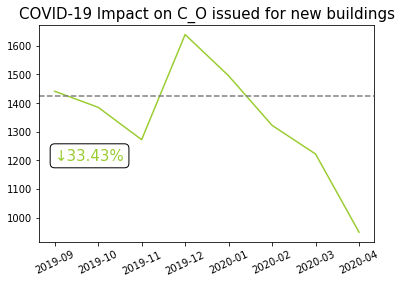

In [17]:
#Certificate of Occupancy issued for new buildings
plt.plot("month_name", "c_o_issue", data = data, color = "yellowgreen")

#average Certificate of Occupancy issued for new buildings before March 2020
plt.axhline(y = avg_number,ls = "dashed",color = "grey") 

#title
plt.title("COVID-19 Impact on C_O issued for new buildings",fontsize = 15)

#annotaion: falling rate
bbox_props = dict(boxstyle="round", facecolor = "white")
plt.text(0, 1200, falling_rate_str, size = 15, color = "yellowgreen", bbox=bbox_props)

plt.xticks(rotation=25)
plt.show()